In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle 

from scipy.ndimage.filters import gaussian_filter,convolve
# interactive
from mpl_toolkits.axes_grid1 import make_axes_locatable
# animation
from matplotlib import animation


In [3]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [4]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
from conditionalstats import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

# Load data

In [11]:
refvar = 'PW'
# refvar = 'CRH'

def getDtype(simname):
    return int(simname[-5:-4])

In [32]:
# simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
simname = 'SAM6113_RCE_SST305d2p0r1'
# simname = 'SAM6113_RCE_SST307d1p0r1'
# simname = 'SAM6113_RCE_SST309d1p0r1'
print('simname:',simname)

dtype = getDtype(simname)

if dtype == 1:
    nproc = 256
    dimratio = 1
    ratio_x = 1
    ratio_y = 1
elif dtype == 2:
    nproc = 128
    dimratio = 4
    ratio_x = 2
    ratio_y = 0.5

os.makedirs(os.path.join(moviedir,simname),exist_ok=True)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_%s.2Dcom_1.nc"%(caseid,nproc)

simname: SAM6113_RCE_SST305d2p0r1
caseid: RCE_SST305d2p0r1


In [33]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))

load 2D data


In [34]:
print("load edge")
file_edge = os.path.join(resultdir,simname,"edge_%s.p"%refvar)
setattr(thismodule,"edge",pickle.load(open(file_edge,"rb")))

load edge


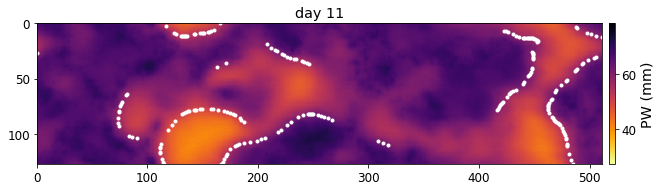

In [36]:
i_t = 10
border_i = edge.edges[i_t].border_i
border_j = edge.edges[i_t].border_j

fig,ax = plt.subplots(figsize=(5*ratio_x+1,5*ratio_y))

vmin = np.min(data2D[refvar])
vmax = np.max(data2D[refvar])

h = ax.imshow(data2D[refvar].values[i_t],cmap='inferno_r',\
          vmin=vmin,vmax=vmax)

ax.scatter(border_j,border_i,marker='.',c='w')
ax.set_xlim((0,nproc*dimratio-1))
ax.set_ylim((nproc-1,0))

t = ax.set_title('day %2.0f'%data2D.time[i_t]) 

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='%d%%'%(int(3/np.sqrt(dimratio))), pad=0.1)
cbar = fig.colorbar(h, cax=cax, orientation='vertical')
cbar.set_label('%s (%s)'%(refvar,data2D[refvar].units))

In [39]:
def makeMovie():
    
    i_tmin = 0
    i_tmax = int(data2D.time[-1])

    # range
    vmin = np.min(data2D[refvar])
    vmax = np.max(data2D[refvar])
    
    # initialize
    h = ax.imshow(data2D[refvar].values[i_tmin],cmap='inferno_r',\
              vmin=vmin,vmax=vmax)
    
    # text
    ax.set_xlim((0,nproc*dimratio-1))
    ax.set_ylim((nproc-1,0))
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title('day %2.0f'%data2D.time[i_tmin]) 

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='%d%%'%(int(3/np.sqrt(dimratio))), pad=0.1)
    cbar = fig.colorbar(h, cax=cax, orientation='vertical')
    cbar.set_label('%s (%s)'%(refvar,data2D[refvar].units))
    
    # loop function
    def update(i_t):
        
        ax.cla()
        
        print(i_t,end=', ')

        # background
        h = ax.imshow(data2D[refvar].values[i_t],cmap='inferno_r',\
            vmin=vmin,vmax=vmax)

        # edge
        border_i = edge.edges[i_t].border_i
        border_j = edge.edges[i_t].border_j
        ax.scatter(border_j,border_i,marker='.',c='w')
        
        # text
        ax.set_xlim((0,nproc*dimratio-1))
        ax.set_ylim((nproc-1,0))
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title('day %2.0f'%data2D.time[i_t]) 
        
        return
    
    # shift figure to the left for display
    fig.tight_layout(h_pad=0.5)

    anim = animation.FuncAnimation(fig, update,
                                   frames=range(i_tmin,i_tmax), interval=200, blit=False)

    writer = animation.writers['ffmpeg'](fps=3)
    # mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

    anim.save(movie_path,writer=writer,savefig_kwargs={'bbox_inches':'tight'})

Make movie
0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 

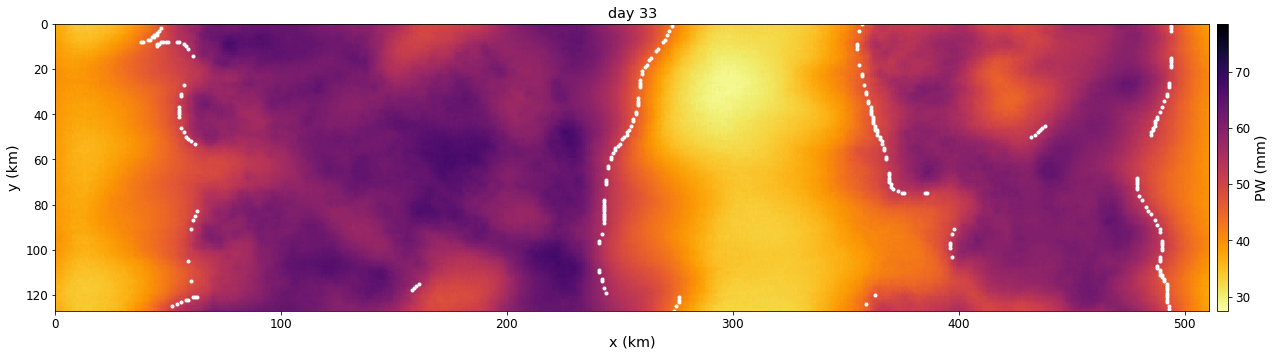

In [41]:
print("Make movie")

# fig,ax = plt.subplots(figsize=(5*ratio_x+1,5*ratio_y))
fig,ax = plt.subplots(figsize=(5*dimratio+1,5))

movie_path = os.path.join(moviedir,simname,'%s_with_edge.mp4'%(refvar))
makeMovie()

## Both CRH and PW

In [21]:
refvars = 'CRH','PW'

In [28]:
# simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
simname = 'SAM6113_RCE_SST307d1p0r1'
print('simname:',simname)

os.makedirs(os.path.join(moviedir,simname),exist_ok=True)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_256.2Dcom_1.nc"%caseid

simname: SAM6113_RCE_SST307d1p0r1
caseid: RCE_SST307d1p0r1


In [29]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))

load 2D data


In [30]:
print("load edges")
for refvar in refvars:
    
    file_edge = os.path.join(resultdir,simname,"edge_%s.p"%refvar)
    setattr(thismodule,"edge_%s"%refvar,pickle.load(open(file_edge,"rb")))

load edges


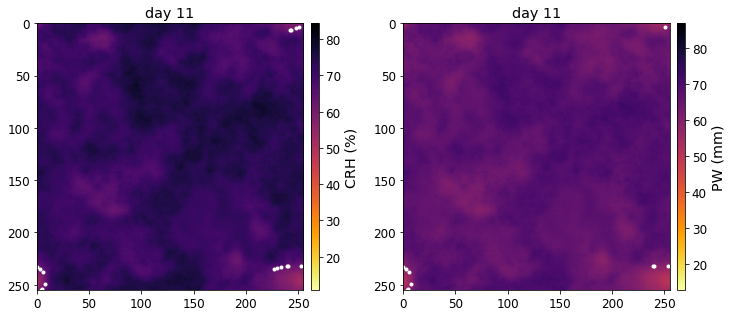

In [31]:
i_t = 10    


fig,axs = plt.subplots(ncols=2,figsize=(12,5))

for refvar,ax in zip(refvars,axs):
    
    edge = getattr(thismodule,"edge_%s"%refvar)
    setattr(thismodule,"border_i",edge.edges[i_t].border_i)
    setattr(thismodule,"border_j",edge.edges[i_t].border_j)

    vmin = np.min(data2D[refvar])
    vmax = np.max(data2D[refvar])

    h = ax.imshow(data2D[refvar].values[i_t],cmap='inferno_r',\
              vmin=vmin,vmax=vmax)

    ax.scatter(border_j,border_i,marker='.',c='w')
    ax.set_xlim((0,255))
    ax.set_ylim((255,0))

    t = ax.set_title('day %2.0f'%data2D.time[i_t]) 

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(h, cax=cax, orientation='vertical')
    cbar.set_label('%s (%s)'%(refvar,data2D[refvar].units))

In [32]:
def makeMovie():
    
    i_tmin = 0
    i_tmax = int(data2D.time[-1])
    
    i_t = i_tmin

    for refvar,ax in zip(refvars,axs):
        
        edge = getattr(thismodule,"edge_%s"%refvar)
        setattr(thismodule,"border_i",edge.edges[i_t].border_i)
        setattr(thismodule,"border_j",edge.edges[i_t].border_j)

        vmin = np.min(data2D[refvar])
        vmax = np.max(data2D[refvar])

        h = ax.imshow(data2D[refvar].values[i_t],cmap='inferno_r',\
                  vmin=vmin,vmax=vmax)

        ax.scatter(border_j,border_i,marker='.',c='w')
        ax.set_xlim((0,255))
        ax.set_ylim((255,0))
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')

        t = ax.set_title('day %2.0f'%data2D.time[i_t]) 

        # colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.1)
        cbar = fig.colorbar(h, cax=cax, orientation='vertical')
        cbar.set_label('%s (%s)'%(refvar,data2D[refvar].units))
        
    # loop function
    def update(i_t):
        
        print(i_t,end=', ')

        for refvar,ax in zip(refvars,axs):
            
            ax.cla()
        
            # background
            vmin = np.min(data2D[refvar])
            vmax = np.max(data2D[refvar])

            h = ax.imshow(data2D[refvar].values[i_t],cmap='inferno_r',\
                      vmin=vmin,vmax=vmax)

            # edge
            edge = getattr(thismodule,"edge_%s"%refvar)
            setattr(thismodule,"border_i",edge.edges[i_t].border_i)
            setattr(thismodule,"border_j",edge.edges[i_t].border_j)

            ax.scatter(border_j,border_i,marker='.',c='w')
            
            # Text
            ax.set_xlim((0,255))
            ax.set_ylim((255,0))
            ax.set_xlabel('x (km)')
            ax.set_ylabel('y (km)')
            ax.set_title('day %2.0f'%data2D.time[i_t]) 
        
        return
    
    # shift figure to the left for display
    fig.tight_layout(h_pad=0.5)

    anim = animation.FuncAnimation(fig, update,
                                   frames=range(i_tmin,i_tmax), interval=200, blit=False)

    writer = animation.writers['ffmpeg'](fps=3)
    # mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

    anim.save(movie_path,writer=writer)

Make movie
0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

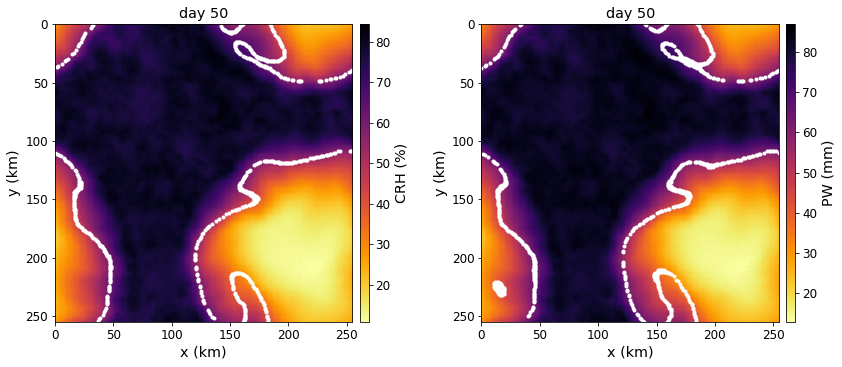

In [33]:
print("Make movie")

fig,axs = plt.subplots(ncols=2,figsize=(12,5))

movie_path = os.path.join(moviedir,simname,'%s_with_edge.mp4'%('_'.join(refvars)))
makeMovie()